<h1><center>Generative Adversarial Networks</center></h1>

## Домашнее задание
1. Обучить генератор создавать точки, которые будут лежать на графике функции
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import math

In [256]:
def func(x):
    y = np.sin(x)/x - x/10
    return y

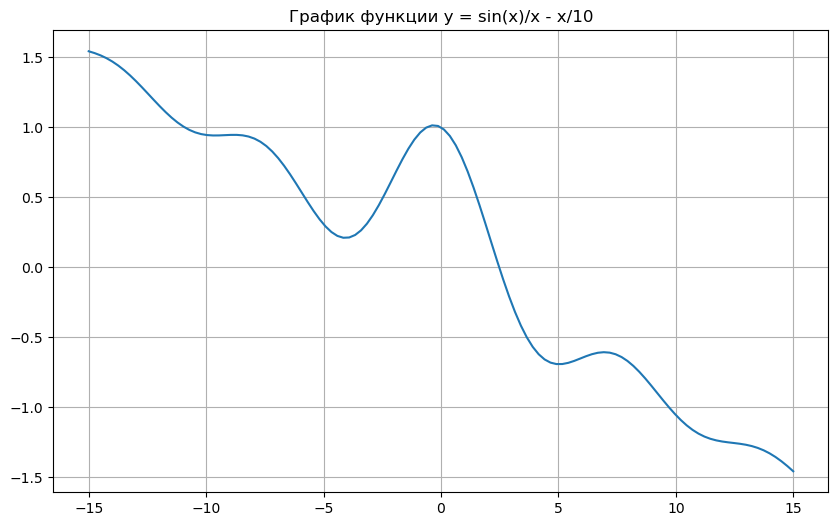

In [257]:
plt.figure(figsize=(10, 6))

x = np.linspace(-15, 15, 120)
y = func(x)

plt.plot(x, y)
plt.title('График функции y = sin(x)/x - x/10')
plt.grid()
plt.show()

In [258]:
class Generator(nn.Module):
    def __init__(self, latent_dim=4, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        self.lrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.lrelu(x)
        x = self.fc3(x)
    
        return x

In [259]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.lrelu = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.lrelu(x)
        x = self.fc2(x)
        x = self.lrelu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [260]:
class Numbers(torch.utils.data.Dataset):
    def __init__(self, length):
        self.length = length
        self.data = (torch.rand((length, 1)) * 2 - 1) * 15 # генерируем равномерное распределение от -30 до 30
        self.data = torch.stack((self.data, func(self.data)), dim=1)
        self.data = torch.squeeze(self.data)
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.length

In [276]:
torch.random.manual_seed(10)

data = Numbers(50000)
BATCH_SIZE = 512

loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

In [277]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [278]:
lr = 0.0001
epochs = 300
latent_dim = 4

In [279]:
torch.random.manual_seed(10)
torch.backends.cudnn.deterministic = True

[Epoch 1/300] [D loss: 0.49795761704444885] [G loss: 0.6912410259246826]


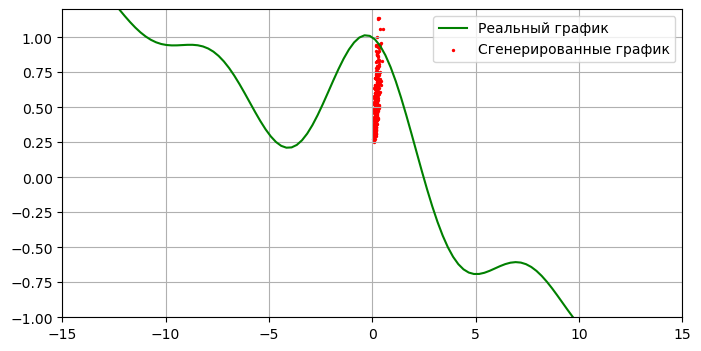

[Epoch 50/300] [D loss: 0.6737630367279053] [G loss: 0.7064971923828125]


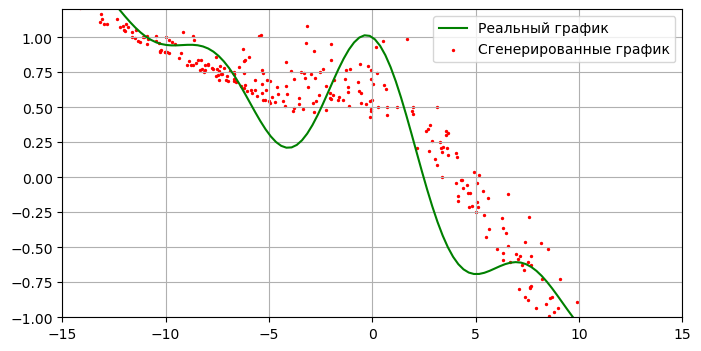

[Epoch 100/300] [D loss: 0.6851625442504883] [G loss: 0.6948813796043396]


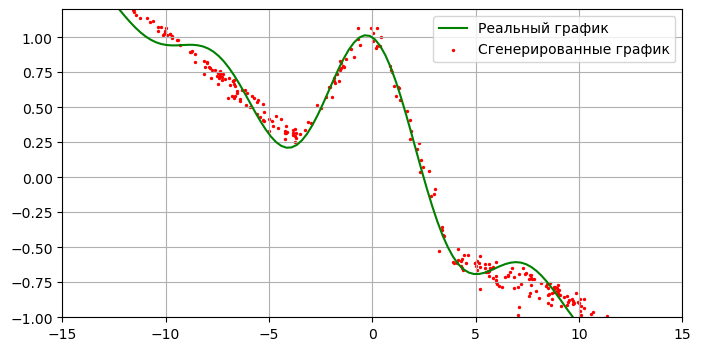

[Epoch 150/300] [D loss: 0.6885879635810852] [G loss: 0.6941897869110107]


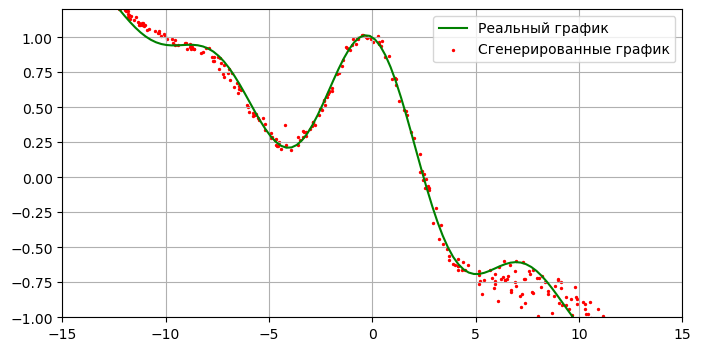

[Epoch 200/300] [D loss: 0.6903730630874634] [G loss: 0.6899465322494507]


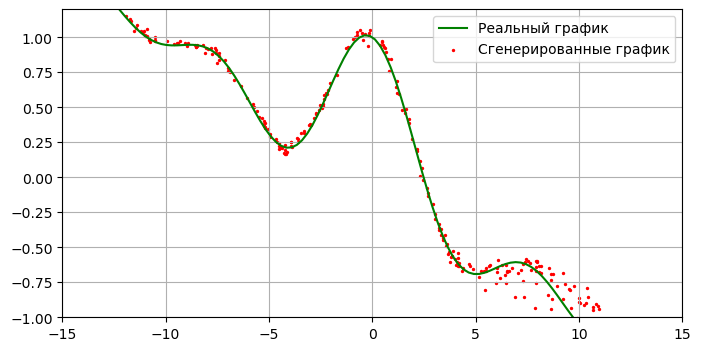

[Epoch 250/300] [D loss: 0.6892269849777222] [G loss: 0.6863654851913452]


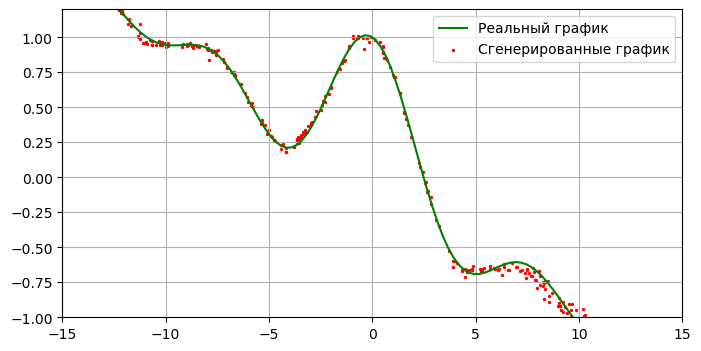

[Epoch 300/300] [D loss: 0.6952946186065674] [G loss: 0.7042613625526428]


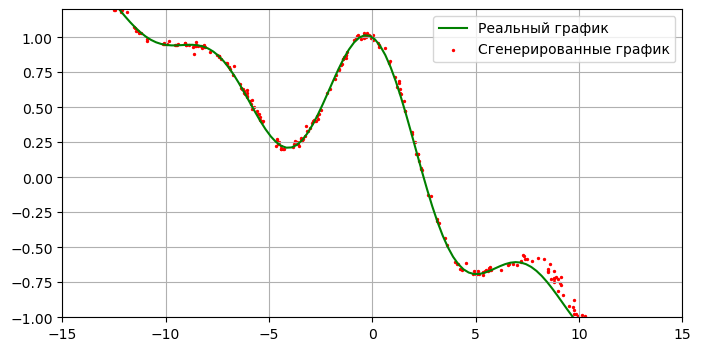

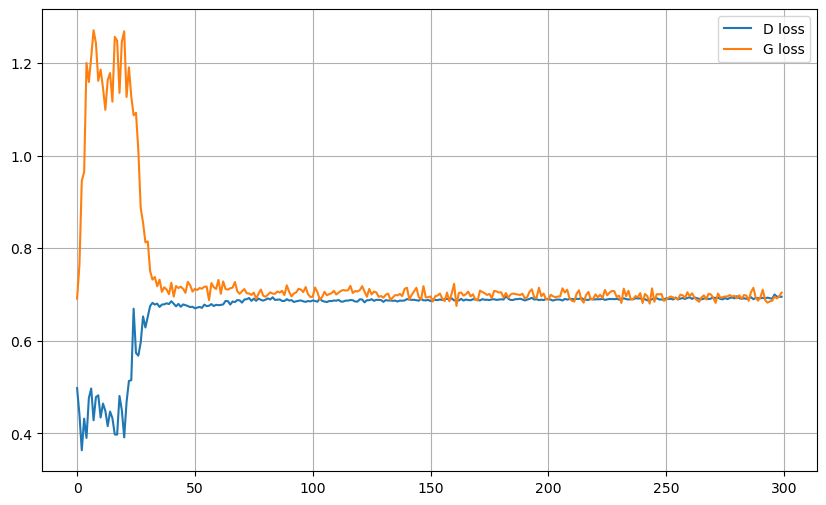

In [280]:
generator = Generator(latent_dim=latent_dim, hidden_dim=64).to(device)
discriminator = Discriminator(64).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

adversarial_loss = torch.nn.BCELoss()

d_loss_history = []
g_loss_history = []

for epoch in range(epochs):
    for i, xy in enumerate(loader):
        
        # Создаём векторы таргетов реальных и сгенерированных данных для дискриминатора
        real = torch.FloatTensor(len(xy), 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(len(xy), 1).fill_(0.0).to(device)

        xy = xy.to(device)

        # Генерируем вектор шума z
        z = torch.randn((len(xy), latent_dim)).to(device)
        
        # Создаём пары x, y генератором
        gen_numbers = generator(z)

######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(xy)
        
        # Сравниваем предсказанные значения дискриминатора (на основе реальных данных) с настоящими.
        # Дискриминатор штрафуется, если не может распознать реальные данные.
        d_real_loss = adversarial_loss(real_pred, real)
        
        # Подаём сгенерированые данные на дискриминатор 
        fake_pred = discriminator(gen_numbers)
        
        # Рассчитываем ошибку предсказанного с фейковыми лейблами.
        # Дискриминатор штрафуется, если принимает сгенерированные данные за реальные.
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # Усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Делаем шаг обучения дискриминатора
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # Генерируем вектор шума z
        z = torch.randn((len(xy), latent_dim)).to(device)
        
        # Создаём пары x, y генератором
        gen_numbers = generator(z)

        # Подаём сгенерированые данные на дискриминатор 
        fake_pred = discriminator(gen_numbers)
    
        # Сравниваем предсказанные значения дискриминатора (на основе сгенерировнных данных) с настоящими.
        # Генератор штрафуется, если дискриминатор может отличить сгенерированные данные от реальных.
        g_loss = adversarial_loss(fake_pred, real)
        
        # Делаем шаг обучения генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

    d_loss_history.append(d_loss.item())
    g_loss_history.append(g_loss.item())
    
    # Каждые 60 эпох обучения будем выводить график 
    # заданной функции и сгенерированные точки
    if epoch == 0 or (epoch+1) % 50 == 0:
        with torch.no_grad():
            # display.clear_output(wait=False)

            print(f"[Epoch {epoch+1}/{epochs}]", end=' ')
            print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 

            plt.figure(figsize=(8, 4))

            plt.plot(x, y, label='Реальный график', c='g')
            gen_numbers = gen_numbers.cpu().detach().numpy()
            plt.scatter(gen_numbers[:, 0], gen_numbers[:, 1], s=2, c='r', label='Сгенерированные график')
            plt.xlim(-15, 15)
            plt.ylim(-1, 1.2)
            plt.grid()
            plt.legend()
            plt.show()

# Также в конце обучения посмотрим на график лоссов состязающихся нейросетей
plt.figure(figsize=(10, 6))            
plt.plot(d_loss_history, label='D loss')
plt.plot(g_loss_history, label='G loss')
plt.grid()
plt.legend()
plt.show()

### Вывод: GAN (генератор) из шума (случайных значений) построил довольно точный график за 100 эпох, далее его точность медленно увеличивалась, что видно на графике потерь D loss, G loss. На 300 эпохе потери D loss, G loss выравниваются и сгенерированный график наиболее точно повторяет реальный. GAN (генератор) очень чувствителен к lr, большое его значение (>0.005) ломает  работу нейронной сети. Прочие гиперпараметры (epochs,latent_dim) также выбраны опытным путем и оказывают заметное влияние на точность работы GAN (генератора)